In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import keras.utils as image

In [ ]:
def plot_mnist(images1, labels1 = None, images2 = None, labels2 = None,n=10):
    """
    Plots n images in a row with their labels. Can plot two rows of images.
    Args:
        images1 (np.array): array of images
        labels1 (list, optional): labels for images1. Defaults to None.
        images2 (np.array, optional): array of images in the second row. Defaults to None.
        labels2 (list, optional): labels for images2. Defaults to None.
        n (int, optional): number of images to plot. Defaults to 10.
    """
    plt.figure(figsize=(2*n, 4))
    if images2 is None:
        nr_rows = 1
    else:
        nr_rows = 2
    for i in range(n):
    # display original
        ax = plt.subplot(nr_rows, n, i + 1)
        img = images1[i]
        if len(img.shape) > 2:
            img = tf.squeeze(img)
        plt.imshow(img)
        if labels1 is not None:
            plt.title(labels1[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if images2 is not None:
    # display reconstruction
            ax = plt.subplot(nr_rows, n, i + 1 + n)
            img = images2[i]
            if len(img.shape) > 2:
                img = tf.squeeze(img)
            plt.imshow(img)
            if labels2 is not None:
                plt.title(labels2[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

def plot_history(history):
    """
    Plots the loss and accuracy of the model.
    Args:
        history (keras.callbacks.History): Model.fit output
    """
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/data/train"

donald	olaf  pooh


In [ ]:
images_train = []
for img in os.listdir(f'/content/drive/MyDrive/data/train/donald'):
    img = image.load_img(f'/content/drive/MyDrive/data/train/donald/{img}', target_size=(512,512))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_train.append(img[0])

In [ ]:
x_train = np.array(images_train)
x_train = x_train.astype('float32') / 255.
x_train.shape

(240, 512, 512, 3)

In [ ]:
images_test = []
for img in os.listdir(f'/content/drive/MyDrive/data/test/donald'):
    img = image.load_img(f'/content/drive/MyDrive/data/test/donald/{img}', target_size=(512,512))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_test.append(img[0])

x_test = np.array(images_test)
x_test = x_test.astype('float32') / 255.
x_test.shape

(30, 512, 512, 3)

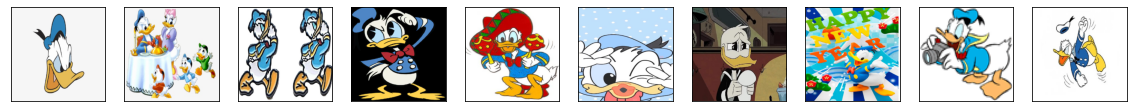

In [ ]:
plot_mnist(x_train)

### Dodawanie szumu

In [ ]:
noise_factor = 2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)  #Dodawanie szumu do obrazków treningowych
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)  #Dodawanie szumu do obrazków testowych
#Pojawia się problem - szum może wyskoczyć poza [0,1]
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)  #Przycinanie wartości spoza [0,1]
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


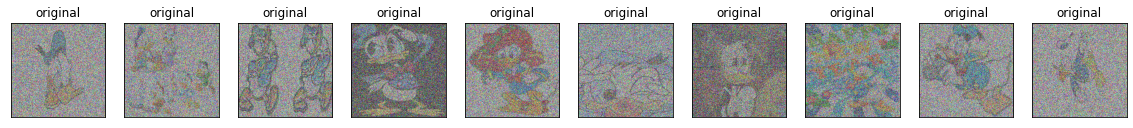

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(tf.squeeze(x_train_noisy[i]))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Autoencoder for denosification

In [ ]:
class Denoise(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(512, 512, 3)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), #Pierwsze są filtry, potem rozmiary filtra. 
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), #Przy podaniu kernel_size =3 tworzy rozmiar filtra 3x3 (kwadrat)
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
x_train_noisy.shape

TensorShape([240, 512, 512, 3])

In [ ]:
x_train.shape

(240, 512, 512, 3)

Epoch 1/100
8/8 [==============================] - 4s 381ms/step - loss: 0.1650 - val_loss: 0.1631
Epoch 2/100
8/8 [==============================] - 3s 361ms/step - loss: 0.1354 - val_loss: 0.0894
Epoch 3/100
8/8 [==============================] - 3s 361ms/step - loss: 0.1201 - val_loss: 0.0954
Epoch 4/100
8/8 [==============================] - 3s 357ms/step - loss: 0.1150 - val_loss: 0.0892
Epoch 5/100
8/8 [==============================] - 3s 360ms/step - loss: 0.1138 - val_loss: 0.0895
Epoch 6/100
8/8 [==============================] - 3s 408ms/step - loss: 0.1112 - val_loss: 0.0882
Epoch 7/100
8/8 [==============================] - 3s 394ms/step - loss: 0.1093 - val_loss: 0.0854
Epoch 8/100
8/8 [==============================] - 3s 361ms/step - loss: 0.1073 - val_loss: 0.0830
Epoch 9/100
8/8 [==============================] - 3s 356ms/step - loss: 0.1036 - val_loss: 0.0810
Epoch 10/100
8/8 [==============================] - 3s 361ms/step - loss: 0.0980 - val_loss: 0.0752
Epoch 11/

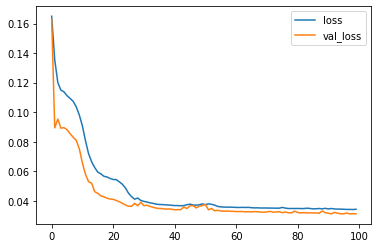

In [ ]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
plot_history(history)

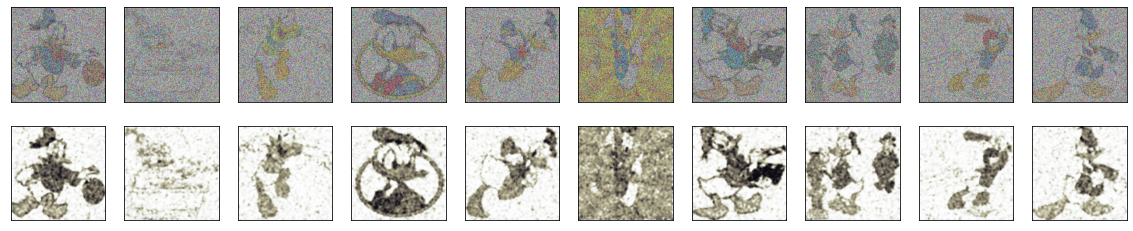

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot_mnist(x_test_noisy, images2 = decoded_imgs)

Epoch 1/500
8/8 [==============================] - 4s 403ms/step - loss: 0.1672 - val_loss: 0.1782
Epoch 2/500
8/8 [==============================] - 3s 365ms/step - loss: 0.1534 - val_loss: 0.1287
Epoch 3/500
8/8 [==============================] - 3s 361ms/step - loss: 0.1255 - val_loss: 0.0892
Epoch 4/500
8/8 [==============================] - 3s 367ms/step - loss: 0.1171 - val_loss: 0.0972
Epoch 5/500
8/8 [==============================] - 3s 363ms/step - loss: 0.1138 - val_loss: 0.0873
Epoch 6/500
8/8 [==============================] - 3s 363ms/step - loss: 0.1110 - val_loss: 0.0899
Epoch 7/500
8/8 [==============================] - 3s 369ms/step - loss: 0.1093 - val_loss: 0.0848
Epoch 8/500
8/8 [==============================] - 3s 368ms/step - loss: 0.1072 - val_loss: 0.0886
Epoch 9/500
8/8 [==============================] - 3s 365ms/step - loss: 0.1044 - val_loss: 0.0832
Epoch 10/500
8/8 [==============================] - 3s 373ms/step - loss: 0.0989 - val_loss: 0.0767
Epoch 11/

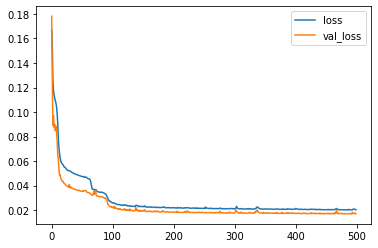

In [ ]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=500,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
plot_history(history)

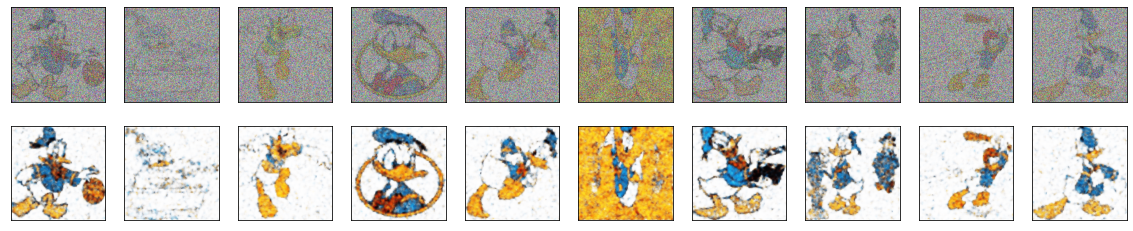

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot_mnist(x_test_noisy, images2 = decoded_imgs)

In [ ]:
class Denoise2(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(512, 512, 3)),
            layers.Conv2D(64, (4, 4), activation='relu', padding='same', strides=2), #Pierwsze są filtry, potem rozmiary filtra. 
            layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=1),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=4, strides=1, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, activation='relu', padding='same'), #Przy podaniu kernel_size =3 tworzy rozmiar filtra 3x3 (kwadrat)
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/500
8/8 [==============================] - 9s 984ms/step - loss: 0.1520 - val_loss: 0.0879
Epoch 2/500
8/8 [==============================] - 8s 975ms/step - loss: 0.1183 - val_loss: 0.1083
Epoch 3/500
8/8 [==============================] - 8s 981ms/step - loss: 0.1154 - val_loss: 0.0893
Epoch 4/500
8/8 [==============================] - 8s 960ms/step - loss: 0.1113 - val_loss: 0.0813
Epoch 5/500
8/8 [==============================] - 8s 956ms/step - loss: 0.1082 - val_loss: 0.0838
Epoch 6/500
8/8 [==============================] - 8s 941ms/step - loss: 0.1021 - val_loss: 0.0743
Epoch 7/500
8/8 [==============================] - 8s 935ms/step - loss: 0.0909 - val_loss: 0.0637
Epoch 8/500
8/8 [==============================] - 8s 937ms/step - loss: 0.0757 - val_loss: 0.0581
Epoch 9/500
8/8 [==============================] - 8s 944ms/step - loss: 0.0661 - val_loss: 0.0433
Epoch 10/500
8/8 [==============================] - 8s 935ms/step - loss: 0.0569 - val_loss: 0.0427
Epoch 11/

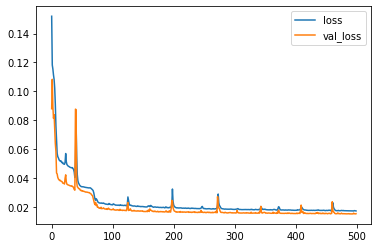

In [ ]:
autoencoder2 = Denoise2()
autoencoder2.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder2.fit(x_train_noisy, x_train,
                epochs=500,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
plot_history(history)

1h 5min

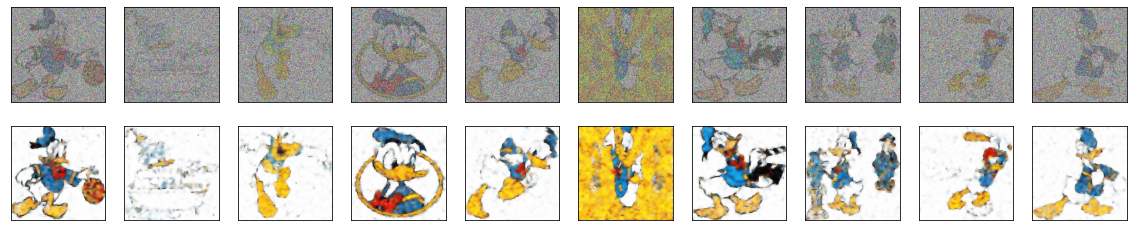

In [ ]:
encoded_imgs = autoencoder2.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder2.decoder(encoded_imgs).numpy()

plot_mnist(x_test_noisy, images2 = decoded_imgs)

In [ ]:
class Denoise3(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(512, 512, 3)),
            layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=2), #Pierwsze są filtry, potem rozmiary filtra. 
            layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=1),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1),
            
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=4, strides=1, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, activation='relu', padding='same'), #Przy podaniu kernel_size =3 tworzy rozmiar filtra 3x3 (kwadrat)
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/200
8/8 [==============================] - 32s 2s/step - loss: 0.1397 - val_loss: 0.0912
Epoch 2/200
8/8 [==============================] - 8s 987ms/step - loss: 0.1143 - val_loss: 0.0817
Epoch 3/200
8/8 [==============================] - 8s 1s/step - loss: 0.1038 - val_loss: 0.0736
Epoch 4/200
8/8 [==============================] - 8s 1s/step - loss: 0.0934 - val_loss: 0.0863
Epoch 5/200
8/8 [==============================] - 8s 1s/step - loss: 0.0756 - val_loss: 0.0565
Epoch 6/200
8/8 [==============================] - 8s 995ms/step - loss: 0.0649 - val_loss: 0.0425
Epoch 7/200
8/8 [==============================] - 8s 985ms/step - loss: 0.0584 - val_loss: 0.0429
Epoch 8/200
8/8 [==============================] - 8s 978ms/step - loss: 0.0553 - val_loss: 0.0407
Epoch 9/200
8/8 [==============================] - 8s 977ms/step - loss: 0.0537 - val_loss: 0.0395
Epoch 10/200
8/8 [==============================] - 8s 979ms/step - loss: 0.0530 - val_loss: 0.0392
Epoch 11/200
8/8 [==

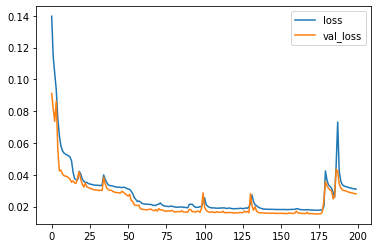

In [ ]:
autoencoder3 = Denoise3()
autoencoder3.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder3.fit(x_train_noisy, x_train,
                epochs=200,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
plot_history(history)

In [ ]:
autoencoder3.save_weights('checkpoints/auto3_200epoch')

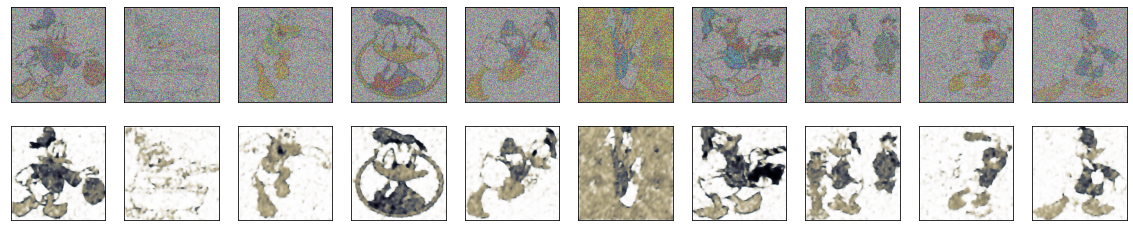

In [ ]:
encoded_imgs = autoencoder3.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder3.decoder(encoded_imgs).numpy()

plot_mnist(x_test_noisy, images2 = decoded_imgs)